In [1]:
import pandas as pd
import numpy as np
import datetime as dt

# My packages
from packages.thesis_sequence_algorithm_nominmax import thesis_sequence_algorithm
from packages.thesis_model_nominmax import evaluate_model

# Visualization<
import matplotlib.pyplot as plt
import time
from dateutil.relativedelta import relativedelta


In [2]:
dataset = pd.read_csv('dataset_final_min.csv', infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
dataset_h = pd.read_csv('dataset_final.csv', infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# Thesis Model

- Prepare warm up period (Define quantity)
- Train the ConvLSTM Model by warm-up period initially
- Prepare previous hourly step (Define Quantity)
- Select optimal correlated leg load by the Power Spectrum
- If Correlated leg > Theta
    - Update and reshape the input vector for ConvLSTM model
    - Implement single step ahead forecast
    - Retrain the ConvLSTM model by the observed hourly load of previous predicted time step
- Else 
    - Implement persistence model
    - Retrain the ConvLSTM model by the observed hourly load of previous predicted time step 


score_PSConvLSTM

# Month Test

In [3]:
dataset_h = dataset_h.loc[:,['Global_active_power','Sub_metering_1','Sub_metering_2','Sub_metering_3','tempC','weekday','time']]
df = dataset_h[(dataset_h.index >= '2008-08-01') & (dataset_h.index < '2010-08-01')]
df

In [6]:
list_theta = [3.8,3.8,3.8,3.8,3.8]
for i in list_theta:
        start_date = df.index[0]
        end_date = start_date + relativedelta(months = 1)
        while end_date < df.index[-1]:
            start_date = pd.to_datetime(start_date) + relativedelta(months = 1)
            end_date = pd.to_datetime(start_date) + relativedelta(months = 1)
            dataset_filtered = df[(df.index >= start_date) & (df.index < end_date)]
            autocorrelation_type = 'power_spectrum'
            warm_up_time = 168
            theta_threshold = i
            leg_days_time = 168
            n_steps = 1
            n_length = 1
            n_input = n_steps * n_length
            n_features = df.shape[1]
            n_out = 1
            epochs = 20
            epochs_retrain = 1
            batch_size = 1
            filters = 36
            activation = 'relu'
            loss = 'mse'
            optimizer = 'adam'
            karnel = (1,2)
            dense_1 = 4
            dense_2 = 1
            model_parameters_PSConvLSTM = thesis_sequence_algorithm(dataset_filtered, 
                                                                    autocorrelation_type, 
                                                                    warm_up_time, 
                                                                    theta_threshold, 
                                                                    leg_days_time, 
                                                                    n_steps, 
                                                                    n_length, 
                                                                    n_input, 
                                                                    n_features, 
                                                                    n_out, 
                                                                    epochs, 
                                                                    batch_size, 
                                                                    filters, 
                                                                    activation, 
                                                                    loss, 
                                                                    optimizer,
                                                                    karnel,
                                                                    epochs_retrain,
                                                                    dense_1,
                                                                    dense_2)
            #RUN ALGO
            start_time = time.time()
            predict_list_PSConvLSTM, observed_list_PSConvLSTM = model_parameters_PSConvLSTM.master_algorithm()
            scores_PSConvLSTM = evaluate_model(predict_list_PSConvLSTM, observed_list_PSConvLSTM)
            score_PSConvLSTM, scores_PSConvLSTM = scores_PSConvLSTM.evaluate_model()
            time_run = (time.time() - start_time)
            # Read results csv
            teste = pd.read_csv('params_test.csv', index_col= 'Unnamed: 0')
            # Register actual version
            resgister_version = {'start_date': start_date, 'end_date': end_date, 'warm_up_time': warm_up_time, 'leg_days' : leg_days_time,
                                'theta_threshold': theta_threshold, 'leg_days_time': leg_days_time ,'n_length': n_length, 'epochs':epochs, 'filters':filters, 
                                'epochs_retrain': epochs_retrain, 'dense_1': dense_1, 'karnels' : [karnel], 
                                'score': score_PSConvLSTM, 'max_loss': np.max(scores_PSConvLSTM), 'time_run': time_run}
            # Create Data Frame
            resgister_version_df = pd.DataFrame(data = resgister_version, index = [pd.to_datetime(dt.datetime.today())] )
            # Concat and save
            pd.concat([teste, resgister_version_df]).to_csv('params_test.csv')

4.031637668609619
17.90216612815857
4.239997625350952
20.256495237350464
4.346306324005127
18.720919847488403
4.480965614318848
19.970385551452637
4.5101637840271
20.079926013946533
4.48023533821106
18.48240828514099
4.464327335357666
20.017788887023926
4.380788564682007
19.876405477523804
4.449471473693848
21.26071310043335
4.625274658203125
20.783589601516724
4.7407286167144775
24.04632329940796
5.146794080734253
23.90155053138733
5.17765736579895
21.16053032875061
5.222679853439331
21.500576972961426
5.0359368324279785
22.829967498779297
4.9598023891448975
23.17335820198059
5.33512282371521
22.699806213378906
5.366871356964111
18.8125159740448
4.964226245880127


In [103]:
analysis_conv = teste[teste['Unnamed: 0'] > '2022-06-07 15:45:12.119314']
analysis_conv.groupby(['theta_threshold'])['score'].mean().sort_values().head(1)

theta_threshold
3.6    0.606819
Name: score, dtype: float64

In [111]:
best_results_for_each_month = analysis_conv.groupby('start_date').min()['score']

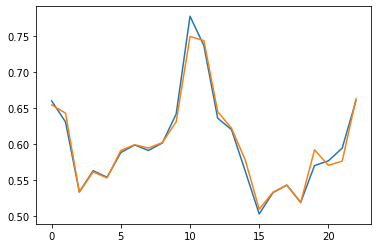

In [121]:
plt.plot(persistence.reset_index()['score'])
plt.plot(best_results_for_each_month.reset_index()['score'])